In [ ]:
#Import dependencies
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [ ]:
# Load your dataset
TRAIN_PATH = "/content/drive/MyDrive/NLP project/train.tsv"
TRAIN_LABELS_PATH = "/content/drive/MyDrive/NLP project/TrainLabels.tsv"
DEV_PATH = "/content/drive/MyDrive/NLP project/dev.tsv"
DEV_LABELS_PATH = "/content/drive/MyDrive/NLP project/DevLabels.tsv"

train_df = pd.read_csv(TRAIN_PATH, sep="\t")
dev_df = pd.read_csv(DEV_PATH, sep="\t")

train_labels_df = pd.read_csv(TRAIN_LABELS_PATH, sep="\t")
dev_labels_df   = pd.read_csv(DEV_LABELS_PATH, sep="\t")

print(train_df.shape, train_labels_df.shape)
print(dev_df.shape, dev_labels_df.shape)


(3991, 12) (19974, 2)
(500, 12) (2499, 2)


In [ ]:
#Reshape Wide → Long (Filler1–Filler5)
def reshape_to_long(df):
    filler_cols = [c for c in df.columns if c.startswith("Filler")]
    long_df = df.melt(
        id_vars=[
            "Id", "Resolved pattern", "Article title", "Section header",
            "Previous context", "Sentence", "Follow-up context"
        ],
        value_vars=filler_cols,
        var_name="FillerNum",
        value_name="Candidate"
    )
    return long_df

long_train = reshape_to_long(train_df)
long_dev   = reshape_to_long(dev_df)

print("Long train:", long_train.shape)
print("Long dev:", long_dev.shape)


Long train: (19955, 9)
Long dev: (2500, 9)


In [ ]:
# Prepare Labels
train_labels_df.columns = ["Key", "LabelText"]
dev_labels_df.columns = ["Key", "LabelText"]

train_labels_df["Label"] = train_labels_df["LabelText"].apply(lambda x: 1 if x == "PLAUSIBLE" else 0)
dev_labels_df["Label"] = dev_labels_df["LabelText"].apply(lambda x: 1 if x == "PLAUSIBLE" else 0)

long_train["Key"] = long_train["Id"].astype(str) + "_" + long_train["FillerNum"].str.replace("Filler", "")
long_dev["Key"]   = long_dev["Id"].astype(str) + "_" + long_dev["FillerNum"].str.replace("Filler", "")

long_train = long_train.merge(train_labels_df[["Key","Label"]], on="Key", how="left")
long_dev   = long_dev.merge(dev_labels_df[["Key","Label"]], on="Key", how="left")

print(long_train.shape, long_dev.shape)


(19955, 11) (2500, 11)


In [ ]:
#Remove missing label rows
long_train = long_train.dropna(subset=["Label"])
long_dev   = long_dev.dropna(subset=["Label"])

long_train["Label"] = long_train["Label"].astype(int)
long_dev["Label"]   = long_dev["Label"].astype(int)


In [ ]:
#FIX: Convert ALL text columns to string
cols = ["Previous context", "Sentence", "Follow-up context", "Candidate"]

for c in cols:
    long_train[c] = long_train[c].astype(str).fillna("")
    long_dev[c]   = long_dev[c].astype(str).fillna("")


In [ ]:
#Build DL text field
long_train["dl_text"] = (
    long_train["Previous context"] + " " +
    long_train["Sentence"] + " " +
    long_train["Follow-up context"] +
    " [SEP] " + long_train["Candidate"]
)

long_dev["dl_text"] = (
    long_dev["Previous context"] + " " +
    long_dev["Sentence"] + " " +
    long_dev["Follow-up context"] +
    " [SEP] " + long_dev["Candidate"]
)

long_train["dl_text"] = long_train["dl_text"].astype(str)
long_dev["dl_text"]   = long_dev["dl_text"].astype(str)


In [ ]:
#Dataset Class
class ClarificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
#Load tokenizer + model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

train_dataset = ClarificationDataset(long_train["dl_text"], long_train["Label"], tokenizer)
dev_dataset   = ClarificationDataset(long_dev["dl_text"], long_dev["Label"], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader   = DataLoader(dev_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Using device: cuda


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Create dataset + dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
).to(device)

In [ ]:
#Training Setup
EPOCHS = 4
LR = 2e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


In [ ]:
#Train & Evaluate Functions
def train_one_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for batch in tqdm(loader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader, device):
    model.eval()
    preds, truths = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1).cpu().tolist()
            preds.extend(batch_preds)
            truths.extend(labels.cpu().tolist())

    acc = accuracy_score(truths, preds)
    f1 = f1_score(truths, preds)

    return total_loss / len(loader), acc, f1, preds, truths


In [ ]:
#Train the Model
train_losses = []
dev_acc_values = []
dev_f1_values = []
dev_losses = []

best_f1 = 0

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")
    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, device)
    print("Train Loss:", train_loss)

    dev_loss, dev_acc, dev_f1, preds, truths = evaluate(model, dev_loader, device)
    print("Dev Loss:", dev_loss)
    print("Dev Acc:", dev_acc)
    print("Dev F1:", dev_f1)

    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    dev_acc_values.append(dev_acc)
    dev_f1_values.append(dev_f1)

    if dev_f1 > best_f1:
        best_f1 = dev_f1
        torch.save(model.state_dict(), "best_roberta.pth")



===== Epoch 1/4 =====


Training: 100%|██████████| 1248/1248 [14:06<00:00,  1.47it/s]


Train Loss: 0.6605369243532037
Dev Loss: 0.6144880978924454
Dev Acc: 0.6338535414165666
Dev F1: 0.0

===== Epoch 2/4 =====


Training: 100%|██████████| 1248/1248 [14:07<00:00,  1.47it/s]


Train Loss: 0.6273176950187638
Dev Loss: 0.5719477739303734
Dev Acc: 0.7078831532613046
Dev F1: 0.5443196004993758

===== Epoch 3/4 =====


Training: 100%|██████████| 1248/1248 [14:08<00:00,  1.47it/s]


Train Loss: 0.5839486836861724
Dev Loss: 0.5616969230828012
Dev Acc: 0.6958783513405362
Dev F1: 0.5443645083932853

===== Epoch 4/4 =====


Training: 100%|██████████| 1248/1248 [14:07<00:00,  1.47it/s]


Train Loss: 0.5322718262338103
Dev Loss: 0.5580791468453256
Dev Acc: 0.7270908363345339
Dev F1: 0.6277292576419214


In [ ]:
#Final Evaluation
model.load_state_dict(torch.load("best_roberta.pth"))

dev_loss, dev_acc, dev_f1, preds, truths = evaluate(model, dev_loader, device)

print("\n=== FINAL RESULTS ===")
print("Dev Loss:", dev_loss)
print("Dev Accuracy:", dev_acc)
print("Dev F1:", dev_f1)
print(classification_report(truths, preds))



=== FINAL RESULTS ===
Dev Loss: 0.5580791468453256
Dev Accuracy: 0.7270908363345339
Dev F1: 0.6277292576419214
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1584
           1       0.63      0.63      0.63       915

    accuracy                           0.73      2499
   macro avg       0.71      0.71      0.71      2499
weighted avg       0.73      0.73      0.73      2499



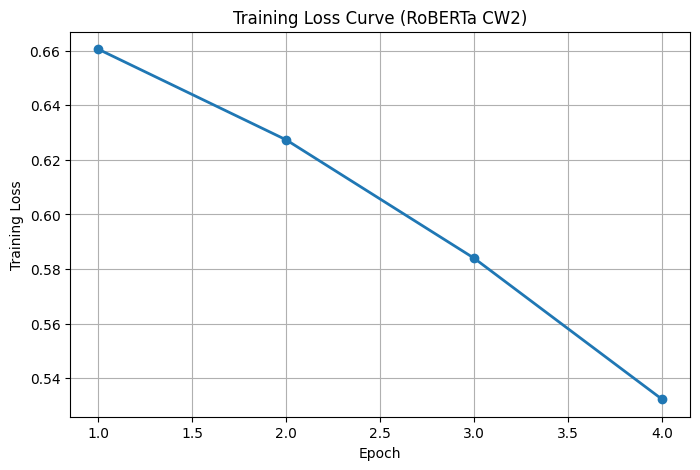

In [ ]:
#Training Loss Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', linewidth=2)
plt.title("Training Loss Curve (RoBERTa CW2)")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True)
plt.show()


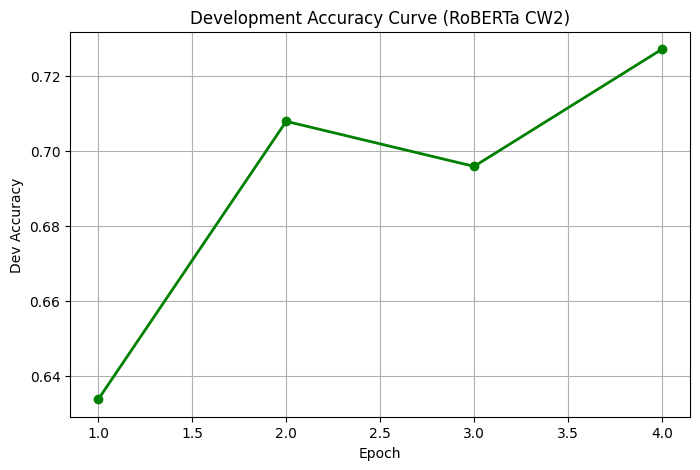

In [ ]:
# Development Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, len(dev_acc_values)+1), dev_acc_values, marker='o', color="green", linewidth=2)

plt.title("Development Accuracy Curve (RoBERTa CW2)")
plt.xlabel("Epoch")
plt.ylabel("Dev Accuracy")
plt.grid(True)
plt.show()


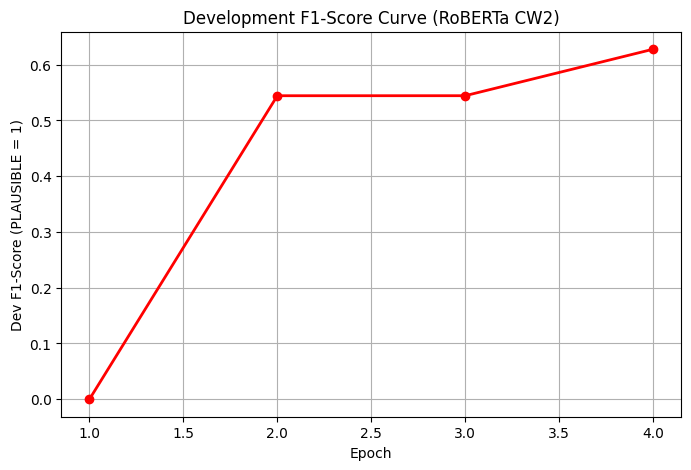

In [ ]:
#Development Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, len(dev_f1_values)+1), dev_f1_values, marker='o', color="red", linewidth=2)
plt.title("Development F1-Score Curve (RoBERTa CW2)")
plt.xlabel("Epoch")
plt.ylabel("Dev F1-Score (PLAUSIBLE = 1)")
plt.grid(True)
plt.show()


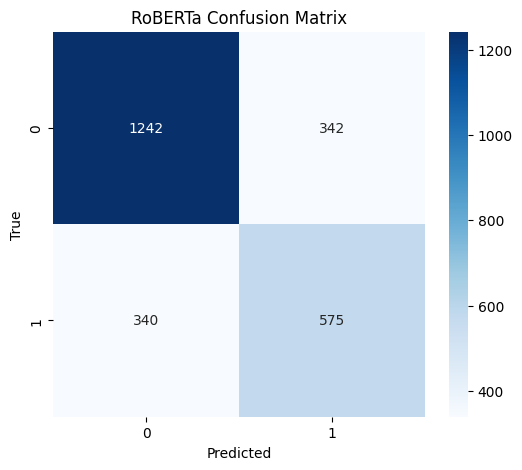

In [ ]:
#Confusion Matrix
cm = confusion_matrix(truths, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("RoBERTa Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
